In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

2022-07-19 20:54:36.035475: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df = pd.read_csv('Training_set.csv')

<AxesSubplot:>

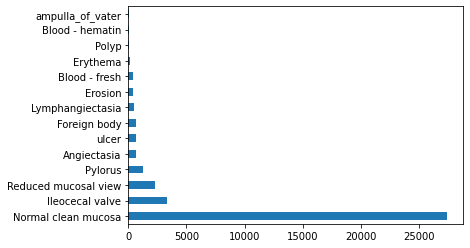

In [3]:
df['label'].value_counts().plot(kind='barh')

In [4]:
df["binary_diagnosis"]=df["label"]
df[df.binary_diagnosis == "Normal clean mucosa"]

,filename,label,binary_diagnosis
0,Image_1.jpg,Normal clean mucosa,Normal clean mucosa
1,Image_2.jpg,Normal clean mucosa,Normal clean mucosa
3,Image_4.jpg,Normal clean mucosa,Normal clean mucosa
4,Image_5.jpg,Normal clean mucosa,Normal clean mucosa
5,Image_6.jpg,Normal clean mucosa,Normal clean mucosa
...,...,...,...
37779,Image_37780.jpg,Normal clean mucosa,Normal clean mucosa
37780,Image_37781.jpg,Normal clean mucosa,Normal clean mucosa
37785,Image_37786.jpg,Normal clean mucosa,Normal clean mucosa
37786,Image_37787.jpg,Normal clean mucosa,Normal clean mucosa


In [5]:
def change(a):
    if a == "Normal clean mucosa":
        a = "NO_AB"
    else:
        a = "AB"
    return a

In [6]:
df['binary_diagnosis'] = df['binary_diagnosis'].apply(change)

In [7]:
df.describe()
df

,filename,label,binary_diagnosis
0,Image_1.jpg,Normal clean mucosa,NO_AB
1,Image_2.jpg,Normal clean mucosa,NO_AB
2,Image_3.jpg,Foreign body,AB
3,Image_4.jpg,Normal clean mucosa,NO_AB
4,Image_5.jpg,Normal clean mucosa,NO_AB
...,...,...,...
37785,Image_37786.jpg,Normal clean mucosa,NO_AB
37786,Image_37787.jpg,Normal clean mucosa,NO_AB
37787,Image_37788.jpg,Normal clean mucosa,NO_AB
37788,Image_37789.jpg,Ileocecal valve,AB


In [8]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['label'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['label'])

print(train['label'].value_counts(), '\n')
print(test['label'].value_counts(), '\n')
print(val['label'].value_counts(), '\n')

Normal clean mucosa     19228
Ileocecal valve          2345
Reduced mucosal view     1627
Pylorus                   856
Angiectasia               485
ulcer                     479
Foreign body              435
Lymphangiectasia          331
Erosion                   283
Blood - fresh             250
Erythema                   89
Polyp                      31
Blood - hematin             7
ampulla_of_vater            6
Name: label, dtype: int64 

Normal clean mucosa     4121
Ileocecal valve          503
Reduced mucosal view     349
Pylorus                  184
Angiectasia              104
ulcer                    102
Foreign body              93
Lymphangiectasia          71
Erosion                   61
Blood - fresh             53
Erythema                  19
Polyp                      6
Blood - hematin            2
ampulla_of_vater           1
Name: label, dtype: int64 

Normal clean mucosa     4121
Ileocecal valve          503
Reduced mucosal view     349
Pylorus                  183
An

In [9]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [10]:
src_dir = 'archive'
for index, row in train.iterrows():
    
    binary_diagnosis = row['binary_diagnosis']

    filename = row['filename'] 
    srcfile = os.path.join(src_dir, filename)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    
    binary_diagnosis = row['binary_diagnosis']

    filename = row['filename'] 
    srcfile = os.path.join(src_dir, filename)
    dstfile = os.path.join(val_dir, binary_diagnosis)

    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    
    binary_diagnosis = row['binary_diagnosis']

    filename = row['filename'] 
    srcfile = os.path.join(src_dir, filename)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [11]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 26452 images belonging to 2 classes.
Found 5669 images belonging to 2 classes.
Found 5669 images belonging to 2 classes.


In [12]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3,3), padding="valid", activation = 'sigmoid'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.27),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=100,
                    validation_data=val_batches)

2022-07-19 20:55:16.470731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 20:55:16.525121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 20:55:16.525294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 20:55:16.525936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/100


2022-07-19 20:55:19.273935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-19 20:55:20.824625: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-19 20:55:21.059796: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


827/827 [==============================] - 35s 38ms/step - loss: 0.5427 - acc: 0.7720 - val_loss: 0.4134 - val_acc: 0.8227
Epoch 2/100
827/827 [==============================] - 31s 38ms/step - loss: 0.4243 - acc: 0.8257 - val_loss: 0.3584 - val_acc: 0.8550
Epoch 3/100
827/827 [==============================] - 35s 42ms/step - loss: 0.3731 - acc: 0.8505 - val_loss: 0.3236 - val_acc: 0.8684
Epoch 4/100
827/827 [==============================] - 34s 41ms/step - loss: 0.3393 - acc: 0.8670 - val_loss: 0.3002 - val_acc: 0.8806
Epoch 5/100
827/827 [==============================] - 34s 41ms/step - loss: 0.3136 - acc: 0.8794 - val_loss: 0.2806 - val_acc: 0.8924
Epoch 6/100
827/827 [==============================] - 33s 39ms/step - loss: 0.2922 - acc: 0.8897 - val_loss: 0.2726 - val_acc: 0.8942
Epoch 7/100
827/827 [==============================] - 34s 41ms/step - loss: 0.2770 - acc: 0.8968 - val_loss: 0.2583 - val_acc: 0.9025
Epoch 8/100
827/827 [==============================] - 33s 40ms/ste

In [48]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

  3/178 [..............................] - ETA: 5s - loss: 0.3245 - acc: 0.9062 

/tmp/ipykernel_14271/3368063525.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


178/178 [==============================] - 5s 26ms/step - loss: 0.1511 - acc: 0.9584
Accuracy:  0.9583700895309448
